# Concurrency

RADICAL-Analytics (RA) offers a method `ra.session.concurrency` that returns a time series, counting the number of tasks which are matching a given pair of timestamps at any point in time. For example, that time series can show the number of concurrent tasks that were scheduled, executed or staging in/out at every point of time, during the execution of the workload.

We plot concurrency time series as a canonical line plot. We can add to the same plot multiple timeseries, showing the relation between diverse components of each RADICAL-Cybertool (RCT) system.

## Prologue

Load all the Python modules needed to profile and plot a RADICAL-EnsembleToolkit (EnTK) session.

In [1]:
import os
import tarfile

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import radical.utils as ru
import radical.pilot as rp
import radical.entk as re
import radical.analytics as ra

Load the RADICAL Matplotlib style to obtain viasually consistent and publishable-qality plots.

In [2]:
plt.style.use(ra.get_mplstyle('radical_mpl'))

Usually, it is useful to record the stack used for the analysis. 

<div class="alert alert-info">

__Note:__ The stack used for the analysis might be different from the stack used to crete the session to analyze. Usually, the two stack have to have the same major release number in order to be compatible.

</div>

In [3]:
! radical-stack


  python               : /Users/mturilli/.virtualenvs/analytics/bin/python3
  pythonpath           : 
  version              : 3.8.11
  virtualenv           : /Users/mturilli/.virtualenvs/analytics

  radical.analytics    : 1.6.7-v0.1.6.7-40-g2e2e026@docs-timestamps
  radical.entk         : 1.6.7
  radical.gtod         : 1.5.0
  radical.pilot        : 1.6.6-v1.6.6-16-g3a1f6dd97@feature-resource_separation
  radical.saga         : 1.6.6
  radical.utils        : 1.6.7



## Session

Name and location of the session we profile.

In [4]:
sid = 're.session.login1.lei.018775.0005'
sdir = 'sessions/'

Unbzip and untar sessions.

In [5]:
sp = sdir+sid+'.tar.bz2'
tar = tarfile.open(sp, mode='r:bz2')
tar.extractall(path=sdir)
tar.close()

Create a ``ra.Session`` object for the session. We are not going to use EnTK-specific traces so we are going to load only the RP traces contained in the EnTK session. Thus, we pass the ``'radical.pilot'`` session type to ``ra.Session``.

<div class="alert alert-warning">
    
__Warning:__ We already know we will want to derive information about pilot(s) and tasks. Thus, we save in memory a session objects filtered for those two identities. This might be too expensive with large sessions, depending on the amount of memory available.

</div>
    
<div class="alert alert-info">
    
__Note:__ We save the ouput of ``ra.Session`` in ``capt`` to avoid polluting the notebook. 

</div>

In [6]:
%%capture capt

sp = sdir+sid

session = ra.Session(sp, 'radical.pilot')
pilots  = session.filter(etype='pilot', inplace=False)
tasks   = session.filter(etype='task' , inplace=False)

## Plotting

We define some pairs of events we want to use for concurrency analysis. We use the ra.session's concurrency method to compute the number of tasks which match the given pair of timestamps at every point in time.

In [7]:
pairs = {'Task Scheduling'  : [{ru.STATE: 'AGENT_SCHEDULING'},
                               {ru.EVENT: 'schedule_ok'     } ],
         'Task Execution'   : [{ru.EVENT: 'exec_start'      },
                               {ru.EVENT: 'exec_stop'       } ]}

time_series = {pair: session.concurrency(event=pairs[pair]) for pair in pairs}

Text(0.5, 0, 'Time (s)')

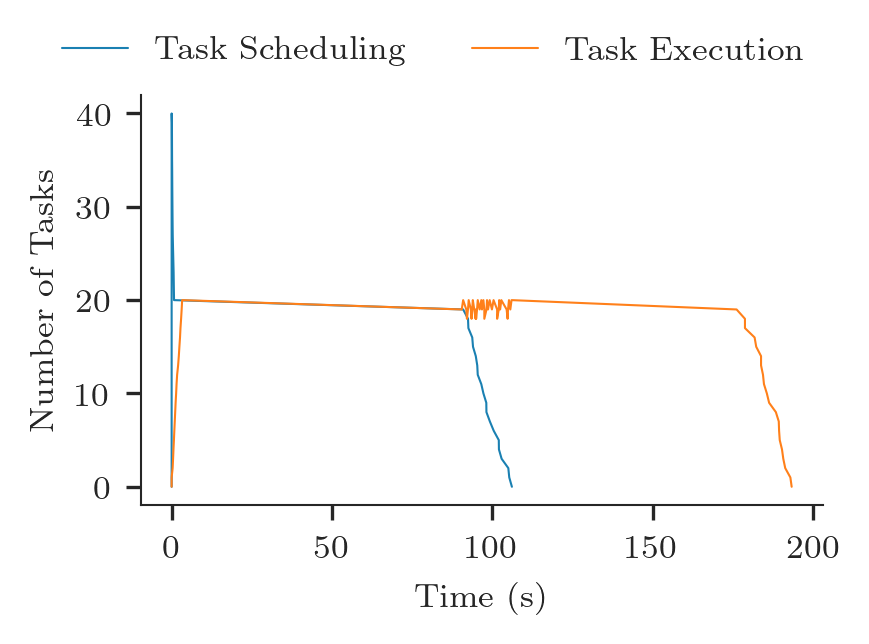

In [8]:
fig, ax = plt.subplots(figsize=(ra.get_plotsize(212)))

for metric in time_series:

    zero = min([e[0] for e in time_series[metric]])
    x = [e[0]-zero for e in time_series[metric]]
    
    y = [e[1] for e in time_series[metric]]
    ax.plot(x, y, label=ra.to_latex(metric))
    
ax.legend(ncol=2, loc='upper left', bbox_to_anchor=(-0.15,1.2))
ax.set_ylabel('Number of Tasks')
ax.set_xlabel('Time (s)')

The plot above shows that 40 tasks were between 'AGENT_SCHEDULING' state and 'schedule_ok' event at the beginning of the execution (dark blue). Few seconds later, 20 tasks are between 'exec_start' and 'exec_stop' events (orange), i.e., they are scheduled and start executing. The first 20 tasks appear to have a relatively uniform duration of ~90s. This is consistent with the task runtime distribution measured in [duration analysis](duration.ipynb). 

When the first 20 tasks start to terminate their execution (i.e., they fire the 'exec_stop' event), the second "generation" of 20 tasks enter between 'exec_start' and 'exec_stop' events (orange), i.e., they are scheduled and start executing. At ~110s, all the tasks have been scheduled so no task remain between 'AGENT_SCHEDULING' state and 'schedule_ok' event. Conistently, the blue line disappears. 

At ~170s also the tasks of the second generation start to terminate their execution. Accordingly, the number of executing tasks decreases, as shown by the orange ling. At ~190s, execution terminates and no lines are visible.